# Детекция объектов с помощью Computer Vision модели и хранилища FINDATALAKE

## Настройка окружения

In [1]:
! wget -O utils.py https://raw.githubusercontent.com/balezz/LacmusTflite/main/utils.py
! pip install minio 
! pip install --upgrade albumentations

--2022-05-24 09:59:40--  https://raw.githubusercontent.com/balezz/LacmusTflite/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8148 (8.0K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.96K  --.-KB/s    in 0s      

2022-05-24 09:59:40 (60.7 MB/s) - ‘utils.py’ saved [8148/8148]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://stackoverflow.com/questions/70537488/cannot-import-name-registermattype-from-cv2-cv2
! pip uninstall -y opencv-python-headless==4.5.5.64
! pip install -y opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

## Загрузка файлов из хранилища FINDATALAKE

In [3]:
from minio import Minio

BUCKET_NAME = 'findatalake'
S3_FILE_NAME = 'LizaAlertDroneDatasetV4_Winter.zip'
TMP_FILE = 'tmp.zip'
MINIO_URL = 'datalake.website:9000'

client = Minio(MINIO_URL,
               access_key='tester-1',
               secret_key='testerpass',
               secure=False)

client.fget_object(BUCKET_NAME, S3_FILE_NAME, TMP_FILE)

In [ ]:
! unzip -n {TMP_FILE}

## Импорт библиотек и подготовка данных

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image

DATA_DIR = './LizaAlertDroneDatasetV4_Winter'

In [6]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['ImageSets', 'Annotations', 'JPEGImages']

In [7]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

with open(DATA_DIR+'/ImageSets/Main/train.txt') as f:
    train_i = f.read().split('\n')[:-1]

train_idxs = [int(t) for t in train_i]

In [8]:
import albumentations as A
def augment(img_array, anns, nn_crop_size, feature_map_size):
    """Get big crop with bboxes and augment
    return crop for NN and labels """
    big_crop_size, other_size, _ = img_array.shape
    assert big_crop_size == other_size
    bboxes = [ann_to_numpy(a) for a in anns]
    category_ids = [1]*len(bboxes)
    
    bbox_params = A.BboxParams(
        format='pascal_voc',
        label_fields=['category_ids'])
    
    transform = A.Compose([
        A.RandomCrop(nn_crop_size, nn_crop_size),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast()
    ], 
        bbox_params=bbox_params
    )
    
    aug = transform(
        image=img_array, 
        bboxes=bboxes, 
        category_ids=category_ids
    )
    # print(aug['bboxes'])
    aug_y = get_feature_map(
        aug['bboxes'],
        nn_crop_size, 
        feature_map_size)
    
    return aug['image'], aug_y

In [9]:
_, x, _, anns  = crop_sample(1, 
                             BIG_CROP_SIZE, 
                             FEATURE_MAP_SIZE,
                             DATA_DIR)[0]

In [10]:
aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)


In [11]:
def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE, DATA_DIR)
        for o in out:
            _, x, y, _ = o
            yield x, y
        
def train_gen():
    for i in train_idxs:
        out = crop_sample(i, BIG_CROP_SIZE, FEATURE_MAP_SIZE, DATA_DIR)
        for o in out:
            _, x, _, anns = o
            aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
            yield aug_x, aug_y

In [12]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_generator(
     train_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

### Вывод функции crop_sample()

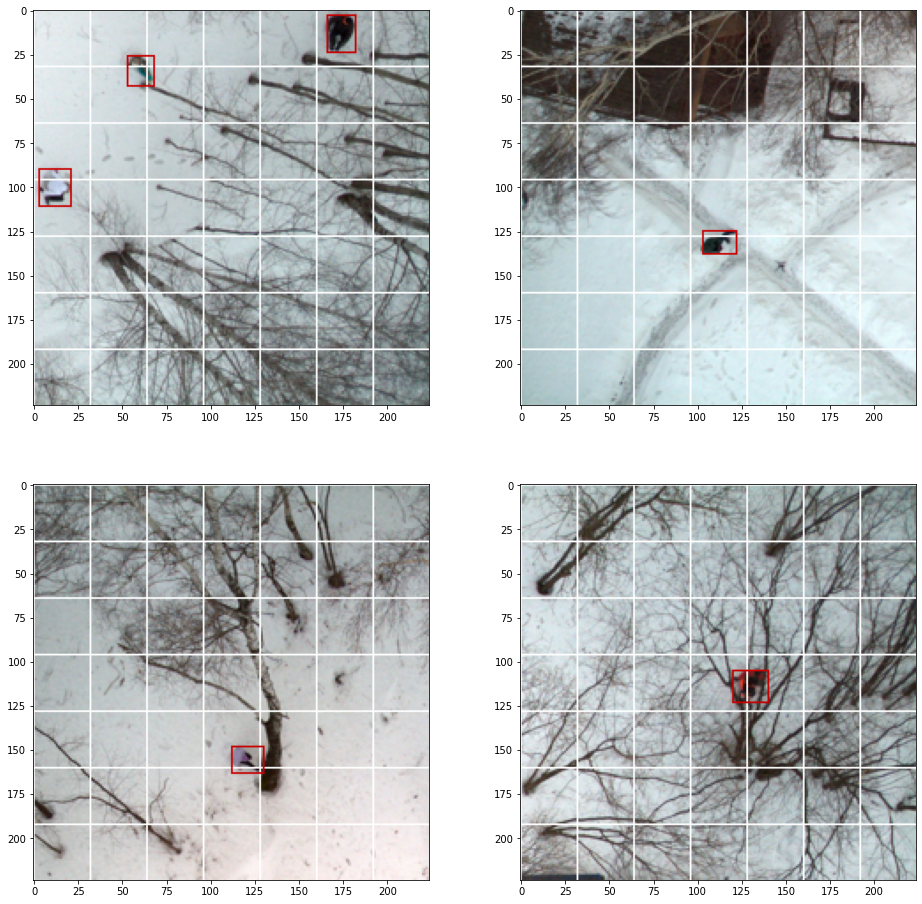

In [13]:
out = crop_sample(0, 
                  CROP_SIZE=INPUT_CROP_SIZE, 
                  FEATURE_MAP_SIZE=FEATURE_MAP_SIZE, 
                  DATA_DIR=DATA_DIR)
plt.figure(figsize=(16,16))

for i in range(4):
    crop_idx, img_arr, y, anns = out[i]
    img = tf.keras.utils.array_to_img(img_arr)
    draw = ImageDraw.Draw(img)
    w,h = img.size
    ff = 32
    for f in range(FEATURE_MAP_SIZE):
        draw.line((ff*f, 0, ff*f, h))
        draw.line((0, ff*f, w, ff*f))
        
    for a in anns:
        bb = a.bbox
        draw.rectangle(bb, outline=(200,0,0))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()

### Вывод тестовых изображений

In [14]:
it = iter(test_dataset)

In [15]:
sample = next(it)
sample[0].shape, sample[1].shape

(TensorShape([8, 224, 224, 3]), TensorShape([8, 7, 7]))

In [16]:
np.array(np.where(y==1))

array([[3],
       [4]])

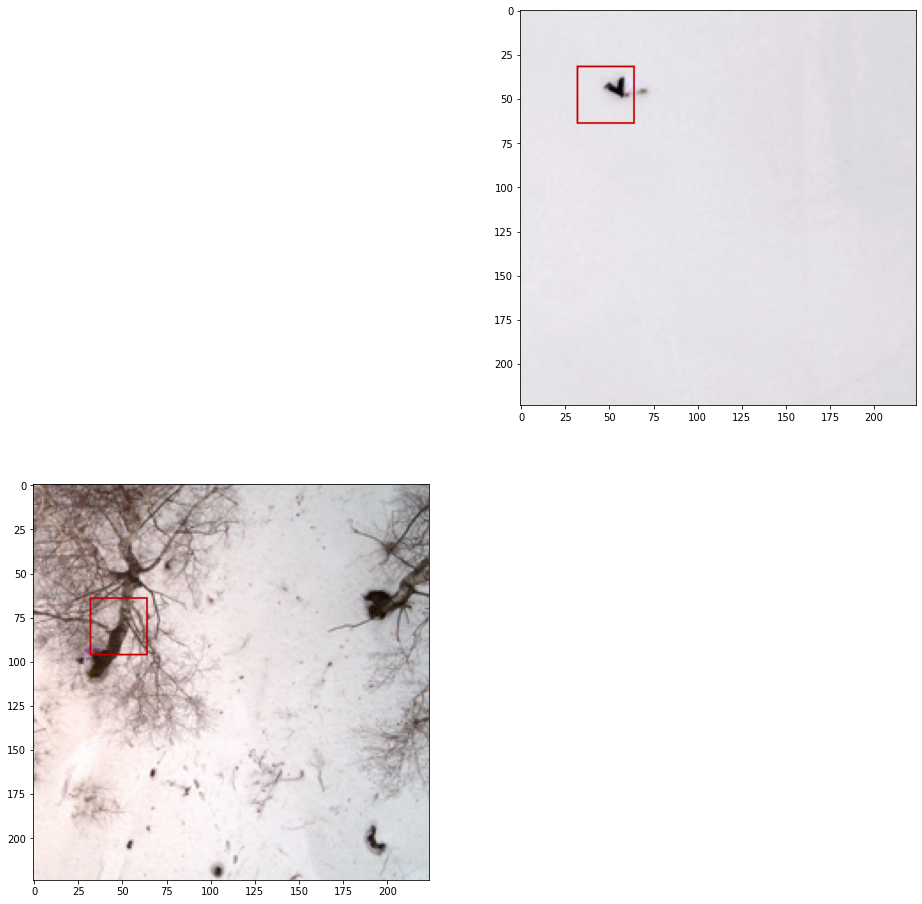

In [17]:
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()
    try:
        img = tf.keras.utils.array_to_img(img_arr)
        xy = np.array(np.where(y==1)).ravel()[::-1]
        bb = np.array([xy, xy+1]).ravel() * 32

        draw = ImageDraw.Draw(img)
        draw.rectangle(bb.tolist(), outline=(200,0,0))
        y_img = Image.fromarray(y*255)
        y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))
    except TypeError:
        continue
        
    plt.subplot(2,2,i+1)
    plt.imshow(img)
plt.show()    

### Вывод изображений из обучающей выборки

In [18]:
it = iter(train_dataset)

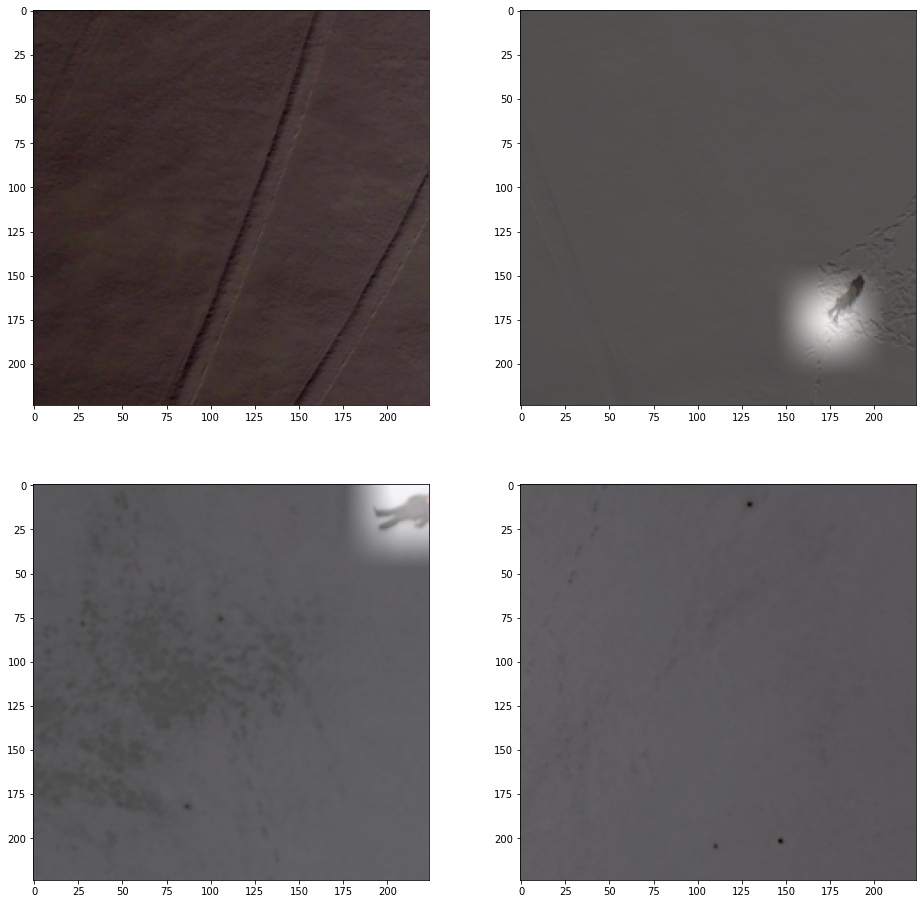

In [19]:
sample = next(it)
sample[0].shape, sample[1].shape
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()

    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()   

### Загрузка модели

In [20]:
model_name = f'B{B}'
model = tf.keras.applications.EfficientNetB0(weights = "imagenet", include_top=False)
model.save('backbones/B0')
#backbone = tf.keras.models.load_model('EnetB0.h5')
backbone=tf.keras.models.load_model(f'backbones/{model_name}')

backbone.summary()

16719872/16705208 [==============================] - 0s 0us/step
INFO:tensorflow:Assets written to: backbones/B0/assets
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7          

In [21]:
x, y_true = next(it)
# x = tf.expand_dims(x, 0)
y_pred = backbone(x)
y_pred.shape

TensorShape([8, 7, 7, 1280])

### Определение новых слоев модели 

In [22]:
class PeDet(tf.keras.Model):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.backbone.trainable = False
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.backbone(x)
        out = self.dense1(out)
        out = self.dense3(out)
        return out

In [23]:
pedet = PeDet(backbone)

### Настройка метрик, логгирования, оптимизатора

In [24]:
THRESH = 0.3
LOG_DIR = f'./logs/GPU{B}'

precision = tf.keras.metrics.Precision(thresholds=THRESH)
recall = tf.keras.metrics.Recall(thresholds=THRESH)
auc = tf.keras.metrics.AUC()

In [25]:
! rm -rf {LOG_DIR}

In [26]:
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    update_freq='epoch'
)

In [27]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=64000
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
pedet.compile(optimizer=optimizer, 
              loss=focal_loss, 
              metrics=[precision, recall, auc])

### Обучение модели

In [ ]:
hist = pedet.fit(train_dataset, 
                 validation_data=test_dataset, 
                 epochs=64,
                callbacks=[tbc]
        )

Epoch 1/64
183/183 [==============================] - 141s 708ms/step - loss: 5.4481 - precision: 0.2790 - recall: 0.4506 - auc: 0.8340 - val_loss: 1.5491 - val_precision: 0.4872 - val_recall: 0.7600 - val_auc: 0.9887
Epoch 2/64
183/183 [==============================] - 130s 697ms/step - loss: 1.4607 - precision: 0.4993 - recall: 0.6510 - auc: 0.9672 - val_loss: 1.0615 - val_precision: 0.4779 - val_recall: 0.8640 - val_auc: 0.9932
Epoch 3/64
183/183 [==============================] - 130s 695ms/step - loss: 1.2819 - precision: 0.5195 - recall: 0.7099 - auc: 0.9767 - val_loss: 0.9467 - val_precision: 0.6218 - val_recall: 0.7760 - val_auc: 0.9940


In [ ]:
pedet.save(f'snapshots/{model_name}')

In [ ]:
hist.history.keys()

## Вывод результатов

In [ ]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('model prec')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()